### Import libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import nltk.data
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

### Define useful functions

In [57]:
def text_process_prelim(review_sentence):
    review_sentence_str = str(review_sentence)
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in review_sentence_str if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now split into words
    if nopunc == '':
        return np.nan
    else:
        return nopunc

In [64]:
def text_process(review_sentence):
        return [word.lower() for word in review_sentence.split()]

### Import dataset

In [59]:
df_preprocessed = pd.read_csv('./datasets/df_preprocessed.csv',lineterminator='\n')

In [60]:
df_preprocessed.tail()

,hotel_name,review_date,review_item_user_review_count,review_score_badge,review_item_header_content,review_info_tag,review_staydate,state,review_sentence,review_label,review_traveler_type,review_time_of_travel
417224,Hampton Inn Seaport Financial District,14 January 2020,1 review,2.0,Below average,"['Business trip', 'Solo traveller', 'Queen Roo...",January 2020,NY,They gave security personnel in the lobby and ...,0,Solo traveler,Winter
417225,Hampton Inn Seaport Financial District,14 January 2020,1 review,2.0,Below average,"['Business trip', 'Solo traveller', 'Queen Roo...",January 2020,NY,People with laud music all night.,0,Solo traveler,Winter
417226,Hampton Inn Seaport Financial District,14 January 2020,1 review,2.0,Below average,"['Business trip', 'Solo traveller', 'Queen Roo...",January 2020,NY,My bathroom smelled like marijuana.,0,Solo traveler,Winter
417227,Hampton Inn Seaport Financial District,9 October 2019,1 review,9.2,Superb,"['Business trip', 'Group', 'Double Room', 'Sta...",October 2019,NY,They always have issues with the TVs?,0,Group,Fall
417228,Hampton Inn Seaport Financial District,9 October 2019,1 review,9.2,Superb,"['Business trip', 'Group', 'Double Room', 'Sta...",October 2019,NY,WiFi and remote controls not working,0,Group,Fall


### Normalization (punctuation)

In [61]:
df_preprocessed['review_sentence'] = df_preprocessed['review_sentence'].apply(text_process_prelim)

### Remove reviews that are now empty

In [62]:
df_preprocessed = df_preprocessed[~pd.isnull(df_preprocessed['review_sentence'])]

In [75]:
len(df_preprocessed)

414282

# Modeling

## Create model pipeline: Vectorization (BoW), TF-IDF, Naive Bayes Classifier

In [116]:
model_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB())  # train on TF-IDF vectors w/ Naive Bayes classifier
])

## Train-validation split

In [96]:
df_preprocessed_features = df_preprocessed.drop('review_label', axis=1)

In [98]:
df_train, df_test, label_train, label_test = train_test_split(df_preprocessed_features, df_preprocessed['review_label'], test_size=0.2)

## Train model

In [105]:
# using only review_sentence as feature (so for instance no review sentence length)
# df_preprocessed['review_sentence_length'] = df_preprocessed['review_sentence'].apply(len)

In [117]:
model_pipeline.fit(df_train['review_sentence'],label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f0468990af0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

## Test model

In [118]:
predictions = model_pipeline.predict(df_test['review_sentence'])

### Print classification report

In [137]:
print(classification_report(label_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     41533
           1       0.88      0.81      0.84     41324

    accuracy                           0.85     82857
   macro avg       0.85      0.85      0.85     82857
weighted avg       0.85      0.85      0.85     82857



### Print confusion matrix

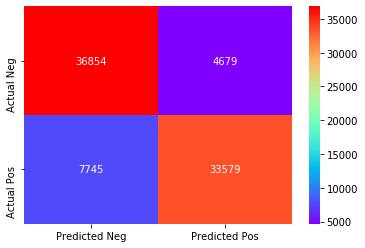

In [124]:
test_cm = confusion_matrix(label_test,predictions)
test_cm_tn, test_cm_fp, test_cm_fn, test_cm_tp = test_cm.ravel()
test_cm_pd = pd.DataFrame(data=test_cm,columns=['Predicted Neg','Predicted Pos'],index=['Actual Neg', 'Actual Pos'])
sns.heatmap(test_cm_pd, annot=True, fmt='d', cmap='rainbow')
plt.show()

In [121]:
#######################################################################

### Vectorization (BoW)

In [65]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_preprocessed['review_sentence'])

In [66]:
# print length of vocabulary
print(len(bow_transformer.vocabulary_))

35955


In [71]:
review_sentence_bow = bow_transformer.transform(df_preprocessed['review_sentence'])

In [79]:
# print info about sparsity
review_sentence_bow_sparsity = (100.0 * review_sentence_bow.nnz / (review_sentence_bow.shape[0] * review_sentence_bow.shape[1]))
print('Shape of Sparse Matrix: ', review_sentence_bow.shape)
print('Amount of Non-Zero occurrences: ', review_sentence_bow.nnz)
print('Sparsity: {} %'.format(round(sparsity,3)))

Shape of Sparse Matrix:  (414282, 35955)
Amount of Non-Zero occurrences:  3889186
Sparsity: 0.026 %


### TF-IDF

In [80]:
tfidf_transformer = TfidfTransformer().fit(review_sentence_bow)

In [82]:
review_sentence_tfidf = tfidf_transformer.transform(review_sentence_bow)

### Naive Bayes Classifier

In [ ]:
nb_model = MultinomialNB().fit(review_sentence_tfidf, messages['label'])